In [109]:
import pandas as pd
import numpy as np

%matplotlib inline

import matplotlib.pyplot as pl

from sklearn import preprocessing as prep


In [110]:
df = pd.read_excel('kickstarter.xlsx')
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0


In [111]:
df.columns

Index(['ID ', 'name ', 'category ', 'main_category ', 'currency ', 'deadline ',
       'goal ', 'launched ', 'pledged ', 'state ', 'backers ', 'country ',
       'usd pledged '],
      dtype='object')

In [112]:
# A quicker way to fix spaces in column names
df.rename(str.strip, axis='columns', inplace=True)
df.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged'],
      dtype='object')

In [113]:
# Fix spaces in column names

def clean_dataframe_columns(df):
    # Create a temporary list to store cleaned column names
    temp_columns = []

    # Loop through current column names
    for col_name in df.columns:
        # For each column name, replace spaces with empty strings
        temp_column_name = col_name.strip().lower()
        temp_column_name = temp_column_name.replace(' ', '_')

        # Save cleaned column name into the temp list
        temp_columns.append(temp_column_name)

    print(temp_columns)

    # Overwriting current column names with cleaned ones
    return temp_columns

In [114]:
df.columns = clean_dataframe_columns(df)
df.columns

['id', 'name', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'usd_pledged']


Index(['id', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd_pledged'],
      dtype='object')

In [115]:
# We'll make the ID column the index
df.set_index('id', inplace=True)


In [116]:
# Decide which columns make sense as variables in your model
df = df[['main_category', 'goal', 'state','backers','usd_pledged']]
df.head()

,main_category,goal,state,backers,usd_pledged
id,,,,,
1000002330,Publishing,1000.0,failed,0,0.0
1000004038,Film & Video,45000.0,failed,3,220.0
1000007540,Music,5000.0,failed,1,1.0
1000011046,Film & Video,19500.0,canceled,14,1283.0
1000014025,Food,50000.0,successful,224,52375.0


In [117]:
# Check datatypes
df.dtypes

main_category     object
goal             float64
state             object
backers            int64
usd_pledged      float64
dtype: object

In [118]:
# Check for missing values
df.isnull().sum()

main_category     0
goal              0
state             0
backers           0
usd_pledged      13
dtype: int64

In [119]:
# Impute missing values in usd_pledged by median
df['usd_pledged'].fillna(df['usd_pledged'].median(), inplace=True)

In [120]:
# Check for missing values
df.isnull().sum()

main_category    0
goal             0
state            0
backers          0
usd_pledged      0
dtype: int64

In [61]:
# Check distributions for every column
df['main_category'].value_counts()

Film & Video    191
Music           152
Art              94
Publishing       90
Games            87
Design           73
Technology       68
Food             67
Fashion          50
Photography      32
Comics           29
Theater          26
Crafts           17
Dance            14
Journalism        9
Name: main_category, dtype: int64

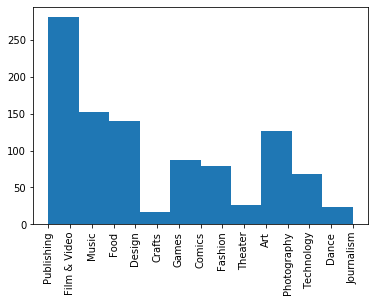

In [62]:
#df['main_category'].hist()

p = pl.hist(df['main_category'])
pl.xticks(rotation='vertical')

pl.show()

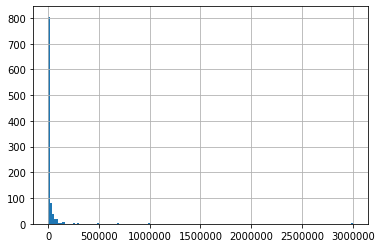

In [63]:
df['goal'].hist(bins=150)

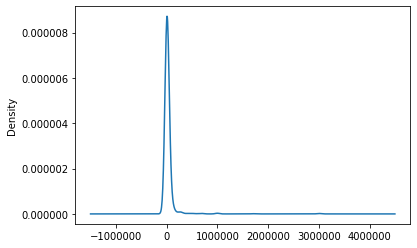

In [64]:
df['goal'].plot.density()

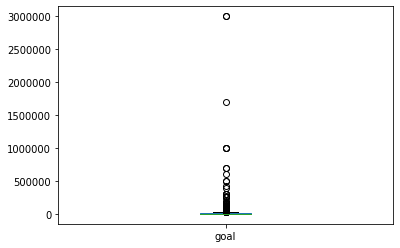

In [65]:
df['goal'].plot.box()

In [66]:
q = "goal >= 500000"
df.query(q)

,main_category,goal,state,backers,usd_pledged
id,,,,,
1001542282,Publishing,1000000.0,failed,1,11.180980
1001708060,Film & Video,500000.0,failed,0,0.000000
1001904214,Technology,1700000.0,canceled,4,1444.017524
1002745522,Food,500000.0,failed,1,5.000000
1003793542,Film & Video,1000000.0,failed,1,25.000000
1004830984,Design,600000.0,live,961,35693.046791
1005237669,Film & Video,3000000.0,failed,2,4.000000
1005364432,Theater,3000000.0,canceled,0,0.000000
1005556588,Games,700000.0,canceled,0,0.000000


In [67]:
# Exclude projects with really high goals
q = "goal < 500000"
df = df.query(q)

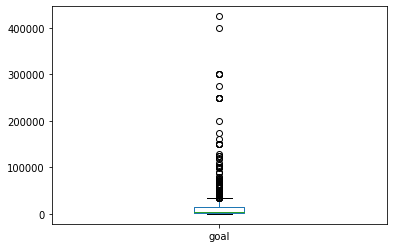

In [68]:
df['goal'].plot.box()

In [69]:
df['state'].value_counts()

failed        494
successful    377
canceled       84
live           17
undefined      13
suspended       3
Name: state, dtype: int64

In [73]:
# Remap 'cancelled', 'undefined', 'suspended' to 'failed'
# Remap 'live' to 'sucessful'

df['state_mapped'] = df['state'].map(
    {'canceled':'failed', 'undefined':'failed','suspended':'failed',
    'live':'successful', 'successful':'successful', 'failed':'failed'}
)
df.head()

,main_category,goal,state,backers,usd_pledged,state_mapped
id,,,,,,
1000002330,Publishing,1000.0,failed,0,0.0,failed
1000004038,Film & Video,45000.0,failed,3,220.0,failed
1000007540,Music,5000.0,failed,1,1.0,failed
1000011046,Film & Video,19500.0,canceled,14,1283.0,failed
1000014025,Food,50000.0,successful,224,52375.0,successful


In [75]:
df['state_mapped'].value_counts()

failed        594
successful    394
Name: state_mapped, dtype: int64

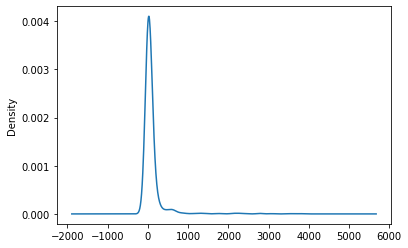

In [76]:
# Check distributions for 'backers'
df['backers'].plot.density()

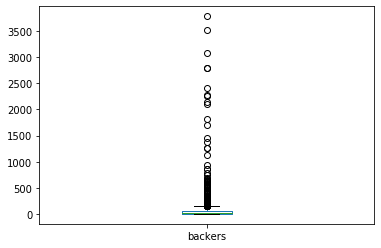

In [77]:
df['backers'].plot.box()

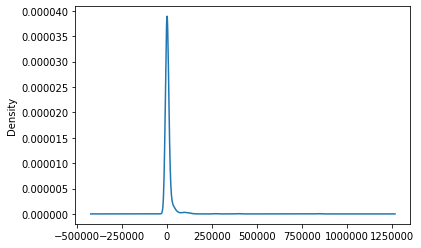

In [78]:
df['usd_pledged'].plot.density()

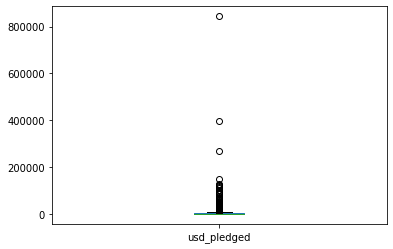

In [79]:
df['usd_pledged'].plot.box()

In [83]:
# Check how many projects raised more money than their goal
q = "usd_pledged - goal > 50000"
df.query(q).shape

(12, 6)

In [85]:
# Now we know that goal, backers, and usd_pledged are heavily skewed

# For goal and usd_pleged, there is a huge difference between min and max
print(df['goal'].min())
print(df['goal'].max())

1.0
425000.0


In [88]:
# Because there is such a huge difference between min and max, 
# let's scale these values

# Note that 'prep' comes from sklearn.preprocessing
df['goal_scaled'] = prep.scale(df['goal'])


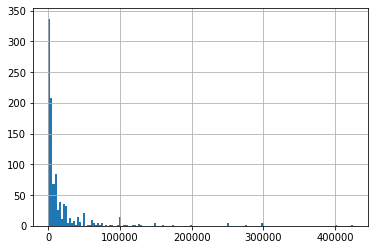

In [89]:
df['goal'].hist(bins=150)

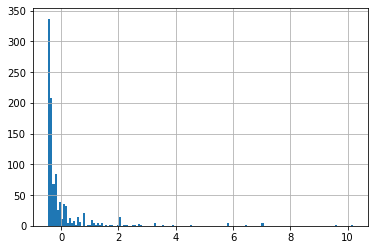

In [90]:
df['goal_scaled'].hist(bins=150)

In [92]:
df['usd_pledged_scaled'] = prep.scale(df['usd_pledged'])

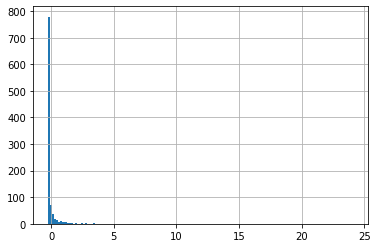

In [93]:
df['usd_pledged_scaled'].hist(bins=150)

In [96]:
# Now let's transform the data
df['goal_transformed'] = df["goal_scaled"].apply(np.sqrt)


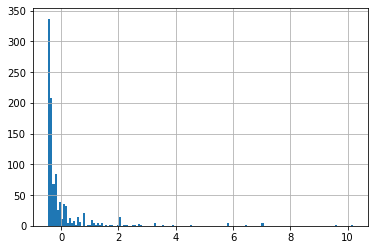

In [98]:
# Before transform
df["goal_scaled"].hist(bins=150)

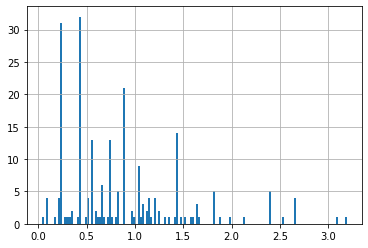

In [100]:
df["goal_transformed"].hist(bins=150)

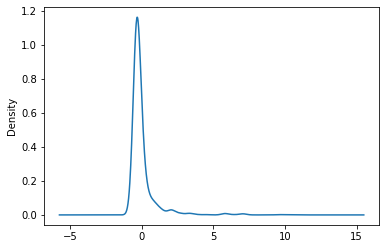

In [101]:
df["goal_scaled"].plot.density()

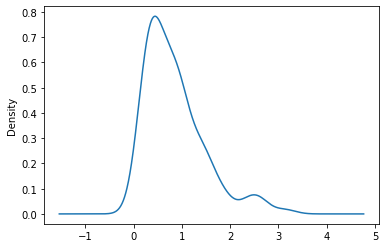

In [102]:
df["goal_transformed"].plot.density()

In [103]:
df['backers_transformed'] = df['backers'].apply(np.sqrt)

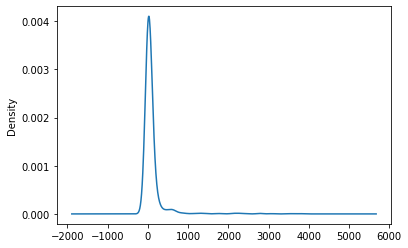

In [104]:
df['backers'].plot.density()

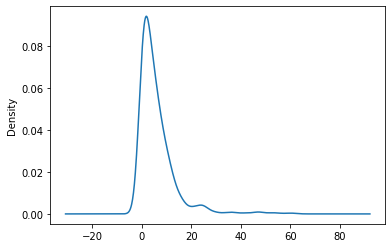

In [105]:
df['backers_transformed'].plot.density()

In [106]:
df['usd_pledged_transformed'] = df['usd_pledged_scaled'].apply(np.sqrt)

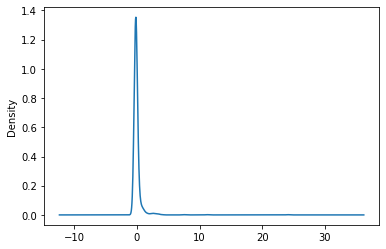

In [107]:
df['usd_pledged_scaled'].plot.density()

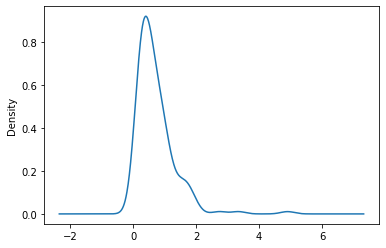

In [108]:
df['usd_pledged_transformed'].plot.density()